# Plotting variations of the BH mass distribution

both physical variations and SFRD variations

In [1]:
import sys
# ##############################
# sys.path.insert(0,'./output/GWTC-3-population-data/utils/')
# input_fname = './output/GWTC-3-population-data//analyses/PowerLawPeak/o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
# output_fname = './plots'
# ##############################

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload  # Python 3.4+
import argparse
import json
import h5py

import matplotlib
import seaborn as sns
from scipy import stats

from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# My own helper funcitons:
import MassDistHelperFunctions as mfunc
reload(mfunc)

#########################################
# Nice little progressbar script 
# to know how far you are with bootstrapping
#########################################
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()


######################################
## locations
proj_dir    = '/n/home04/lvanson/LowMBH_and_StableChannel/'
data_dir    = '/n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/EssentialData/'
save_loc    = proj_dir+'/plots/'

sim_save_str = ''

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,30,35
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Mass dist split by redshift

In [2]:
# Distribution plot function
def plot_mass_distribution(sim_dir = data_dir, sim_sets = ['alphaCE1.0'], x_key = 'M_moreMassive', dco_flavour = "BBH_BHNS", 
                          bins = np.arange(0,50,1),  z_bin_edges = [0,0.5], plot_str = 'stable', average_rate = False,
                           linestyles = ['-','-', '-', '-', '-.', '-', ':', '--', '-.'], markers = ['','','*','','',''], 
                           log = True, logx = False, kde_width = 0.1, show_KDE = True, plot_LIGO = False, Farah21=True, GWTC_3 = False,
                           show_hist = False,  labels = ['$\mathrm{CE \ channel = \ }$', '$\mathrm{stable \ RLOF \ channel = \ }$', '$\mathrm{All = \ }$'],
                           title_text = '', save_plot=False, x_lim=(1.,15),  y_lim = (1e-2,50),  bootstrap = False, bootstraps = 10,
                          colors = ['#488496', '#73bdb3', '#e388b0'], save_name = 'Fiducial.png',
                           xlabel = r'$\mathrm{More \ massive \ component}, \  M_{\mathrm{primary}} \ \rm [M_{\odot}]$', 
                           ylabel = r'$\frac{d\mathcal{R}}{dM_{\mathrm{primary}}} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                         leg_args = None, leg1_args = {'loc':'upper center', 'fontsize':23}):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            sim_dir              --> [string] Location of data
            dco_flavour          --> [string] Which favour of dco do you want ["BBH", "NSNS", "BHNS", "BBH_BHNS"] 

        Returns:
         plot

    """
   
    #########################################
    mass_binw = np.diff(bins)[0]

    plot_lines = []
    leg_labels = []

    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (12, 10))
    
    
    color_plpeak = '#1f78b4'# "#1f78b4"# 'grey'

    rise_range = np.arange(4.5,9,0.5)
    ax.fill_between(rise_range,y1= np.full(len(rise_range),1e-3),y2= np.full(len(rise_range),1e2),
                    color=color_plpeak, alpha = 0.14,zorder = 0,label="$\mathrm{Possible \ rise \ in \ GW-observed \ dist.}$")
#                         label="$\mathrm{Feature \ in \ GW \ data, Farah \ et \ al. \ (2021)}$") 

    # Add legend for ligo data
    legend1 = plt.legend(**leg1_args)

    nplot = 0
    
    ################################################
    # My Simulations
    ################################################
    for sim, sim_set in enumerate(sim_sets):
        print('!!!!!! sim_set', sim_set)
        print('nplot', nplot, '\n')
        ####################################################
        ### ## Reading file ##
        File_location = sim_dir +'/'+sim_set+'/COMPAS_Output_wWeights.h5'
        DCO, DCO_mask  = mfunc.read_data(loc = File_location, DCO_type = "BBH", rate_key = '', read_SFRD = False)
        DCO['q_ZAMS']  =  DCO['Mass@ZAMS(2)']/DCO['Mass@ZAMS(1)']
        HG_HG_MT       =  DCO['experiencedHGHG_MT'] == True
                
        ####################################################
        try:
            Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05' + '_a0.02_b1.48_c4.45_d5.9' + '_zBinned'     # High resolution data has the full key name (also specifying SFRD(z))
            DCO, rateDCO_mask, DCO_mask, rate_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0 = mfunc.read_data(loc = File_location, read_SFRD = True, DCO_type = dco_flavour, rate_key = Rate_key)

        except:
            Rate_key      =  'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05' + '_zBinned'                                 # low resolution data has a different key name (not specifying SFRD(z))
            DCO, rateDCO_mask, DCO_mask, rate_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0 = mfunc.read_data(loc = File_location, read_SFRD = True, DCO_type = dco_flavour, rate_key = Rate_key)

        # # # # # # # # # # # # # # # # # # 
        #first bring it to the same shape as the rate table
        merging_BBH    = DCO[rateDCO_mask]
        #then apply the additional mask based on your prefs
        #HG_HG_MT       = merging_BBH['experiencedHGHG_MT'] == True
        merging_BBH    = merging_BBH[rate_mask]# * HG_HG_MT]

        Red_intr_rate_dens  = intrinsic_rate_density[rate_mask]# * HG_HG_MT]#rate_HG_HG_MT * (DCO['Stellar_Type@ZAMS(1)'][rate_mask] != 16), :]
        #########################################
        # X value and weight
        x_vals              = merging_BBH[x_key]
        # # # # # # # # # # # # # # # # # # 
        ## Calculate average rate density per z-bin, or take rate at z = 0.2
        if average_rate:
            crude_rate_density = mfunc.get_crude_rate_density(intrinsic_rate_density[rate_mask,:], redshifts[:len(intrinsic_rate_density[0,:])+1], z_bin_edges) #
            weights            = crude_rate_density[:,0]
        else:
            i_redshift         = np.where(redshifts == 0.2)[0][0]
            print('i_redshift', i_redshift, '==> z =', redshifts[i_redshift])
            weights            = intrinsic_rate_density[rate_mask,:]
            weights            = weights[:, i_redshift]


        ################################## 
        ### ## Split by channel  ##
        # CE channel
        BBH_CEchannel     = merging_BBH[merging_BBH['CE_Event_Counter'] >0]
        CEchannel_weights = weights[merging_BBH['CE_Event_Counter'] >0]
        # stable RLOF channel
        BBH_stablechannel     = merging_BBH[merging_BBH['CE_Event_Counter'] == 0]
        stablechannel_weights = weights[merging_BBH['CE_Event_Counter'] == 0]

        tables = [BBH_CEchannel, BBH_stablechannel, merging_BBH]
        WEIGHTS_list = [CEchannel_weights, stablechannel_weights, weights]

        ################################################
        # Plot Stable and CE channel seperately
        for i, table in enumerate(tables):
            if len(table) == 0:
                print(labels[i], 'Table is empty!!')
                continue
            # Select which ones to plot
            if plot_str == 'CE':
                if i != 0: continue
            elif plot_str == 'stable':
                if i != 1: continue
            elif plot_str == 'All':
                if i != 2: continue
            elif plot_str == 'channels':
                if i == 2: continue
            #########################################
            Weight                = WEIGHTS_list[i]
            print(labels[i], ' len(table)=', len(table) , ' Rate = ', np.sum(Weight), ' Gpc-3 yr-1')

            #########################################
            # X value and weight
            x_vals                = table[x_key]
            m_Weight              = Weight

            ########################
            # Get the Hist    
            hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
            y_vals = hist/mass_binw
            if logx:
                y_vals = center_bins*y_vals
                    
            center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
            # to prevent overflowing
            min_xkde = min(center_bins[y_vals>1e-5])
            
            # And the KDE
            kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=m_Weight)
            binwidth = np.diff(bin_edge)

            ########################
            # Plot the Hist 
            if show_hist:
                print('nplot', nplot, '\n')
                #plot_lines.append(ax.step(center_bins, y_vals,  where='mid',label = None,#labels[i]+'$%s \mathrm{ \ Gpc^{-3} yr^{-1}}$'%(np.round(np.sum(Weight),1)) , 
                #                          alpha=1.0, lw = 3.5, zorder = i, color= colors[nplot], 
                #                          marker = markers[nplot], markersize = 25, markeredgecolor='k', markeredgewidth=1) ) 
                
                plot_lines.append(ax.plot(center_bins, y_vals, label = None,
                                          alpha=1.0, lw = 3.5, zorder = i, color= colors[nplot], 
                                          marker = markers[nplot], markersize = 25, markeredgecolor='k', markeredgewidth=1) ) 
                
#                 leg_labels.append(labels[nplot]+'$%s$'%(np.round(np.sum(Weight),1)))                    
                
                ########################
                # Bootstrap   
                if bootstrap:
                    indices = np.arange(len(x_vals))
                    hist_vals = np.zeros((bootstraps, len(center_bins))) 
                    for b in progressbar( range(len(hist_vals)), "Bootstrapping "+ labels[i] + ":"):
                        boot_index      = np.random.choice(indices, size=len(indices), replace=True)
                        hist_vals[b], _ = np.histogram(x_vals[boot_index], bins=bins, weights=m_Weight[boot_index],density=False)
                    
                    # calculate 90% tile
                    y_vals = hist_vals/mass_binw
                    if logx:
                        y_vals = y_vals*center_bins
                    percentiles = np.percentile(y_vals, [10., 90.], axis=0)
                    print('nplot',nplot, 'len(colors)', len(colors))
                    ax.fill_between(center_bins, percentiles[0],percentiles[1], alpha=0.4, color=colors[nplot], zorder = 0) # 1-sigma #x_KDE
                    
#                 nplot += 1  
                
            ########################
            # Plot KDE
            if show_KDE:
                print('nplot', nplot, '\n')
                x_KDE = np.arange(min_xkde,50.,0.1)
                KDEy_vals =  kernel(x_KDE)*sum(hist) #re-normalize the KDE
                if logx:
                    KDEy_vals = x_KDE * KDEy_vals # plot m dr/dm
#                     leg_labels.append(labels[nplot]+'$%s \mathrm{\ Gpc^{-3} yr^{-1}}$'%(np.round(np.sum(Weight),1)))
                plot_lines.append(ax.plot(x_KDE, KDEy_vals, label = '', 
                                        color=colors[nplot], lw= 5,  zorder =i+1,ls = linestyles[nplot])) #ls = linestyles[SFRD_i])                    

                ########################
                # Bootstrap   
                if bootstrap:
                    indices = np.arange(len(x_vals))
                    hist_vals = np.zeros((bootstraps, len(x_KDE))  )  #len(center_halfbins) len(x_KDE)
                    for b in progressbar( range(len(hist_vals)), "Bootstrapping "+ labels[i] + ":"):
                        boot_index = np.random.choice(indices, size=len(indices), replace=True)
                        kernel         = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=m_Weight[boot_index])
                        Hist, _        = np.histogram(x_vals[boot_index], bins=bins, weights=m_Weight[boot_index],density=False)
                        hist_vals[b]   = kernel(x_KDE)*sum(Hist)

                    # calculate 1- and 2- sigma percentiles
                    y_vals = hist_vals#/np.diff(half_bins)[0]  #/mass_binw
                    if logx:
                        y_vals = y_vals*center_bins
                    percentiles = np.percentile(y_vals, [10., 90.], axis=0)
                    ax.fill_between(x_KDE, percentiles[0], percentiles[1], alpha=0.4, color=colors[nplot], zorder = 0) #
               

            leg_labels.append(labels[nplot]+'$%s$'%(np.round(np.sum(Weight),1)))
            nplot += 1


    #########################################
    # NS bound
    ax.axvline( x = 2.5, c = 'grey', ls = '--', lw = 5, zorder = 10)
    ax.text(0.02, 0.4, '$\mathrm{NS \ Formation}$', va = 'center', #bbox=dict(facecolor='#e8e8e8', edgecolor='none', pad=8), 
            transform=ax.transAxes, rotation = 90)

    
    #########################################
    # plot values
    ax.grid(True, dashes=(1, 3))
    
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    leg = ax.legend(**leg_args)
    
    #####
    # add legend
    leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
    leg.set_zorder(102)
    leg._legend_box.align = "right"

    plt.gca().add_artist(legend1)

    if average_rate:
        s = ['$[%s \leq z < %s]$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1)]   
        ax.set_title('$\mathrm{%s}$'%(sim_set.replace('_', ' ')) +'  '+s[0])
        ax.text(6, 13, text)
    else:
        ax.set_title(title_text,  x=0.05, y=1. , ha = 'left')


    ax.set_xlabel(xlabel, fontsize = 35)
    ax.set_ylabel(ylabel, fontsize = 40)
    if log:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
        
    if save_plot:
        plt.savefig(save_loc+'/'+save_name , bbox_inches='tight')

    plt.show()


    

# Qcrit/zeta eff

In [ ]:
zeta_list   = [3.5, 4.5, 5.5, 6.0, 6.5]

import MinimumMassFunctions as minf

q_crits     = minf.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
qcrit2_list = q_crits[:,1]


plot_mass_distribution(sim_sets =  ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED'%(ZETA) for ZETA in zeta_list],
                       show_hist = True, show_KDE = False, markers = ['','','','*','',''], colors  = ['#043e00','#098f00', '#72cd05', '#c1cd0d', '#e6d952'], #greens
                       leg_args = {'loc':'upper left', 'bbox_to_anchor':(-0.01,1.01), 'title_fontsize':'20', 'fontsize':'23', 'title':r'$\hspace{0.1cm} (\zeta_{eff}, q_{\rm crit,2}), \ \mathcal{R}_{0.2}$'},
                       leg1_args = {'loc':'upper right', 'fontsize':'23'},
                       bootstrap = True, bootstraps = 50, 
                       save_plot=True,  save_name = 'zetaVariations_betaFIXEDbeta0.5FryerDelayed_HR.pdf', 
                       labels = [r'$(%s, %s), \ $'%(np.round(zeta_list[i],2), np.round(qcrit2_list[i],2)) for i in range(len(qcrit2_list)) ])




# Beta variations

!!!!!! sim_set faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 0 

sum(rateDCO_mask) 2303254
len(DCO[rateDCO_mask]) 2303254 np.shape(intrinsic_rate_density) (2303254, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 2971417 sum(R_pessimistic_CE) 2303254 sum(R_immediateRLOF) 2303254 sum(R_notCHE) 2300405
i_redshift 4 ==> z = 0.2
$(0.25), \ $  len(table)= 36976  Rate =  14.0092224523095  Gpc-3 yr-1
nplot 0 

Bootstrapping $(0.25), \ $:[############################################################] 50/50
nplot 0 len(colors) 5
!!!!!! sim_set faccFIXEDbeta0.25zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 1 

sum(rateDCO_mask) 1745441
len(DCO[rateDCO_mask]) 1745441 np.shape(intrinsic_rate_density) (1745441, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 2702953 sum(R_pessimistic_CE) 1745441 sum(R_immediateRLOF) 1745441 sum(R_notCHE) 1741865
i_redshift 4 ==> z = 0.2
$(0.25), \ $  len(table)= 107880  Rate =  23.9507731386605  Gpc-3 yr-1
nplot 1 

Bootstrapping $(0.25), \ $:[######################

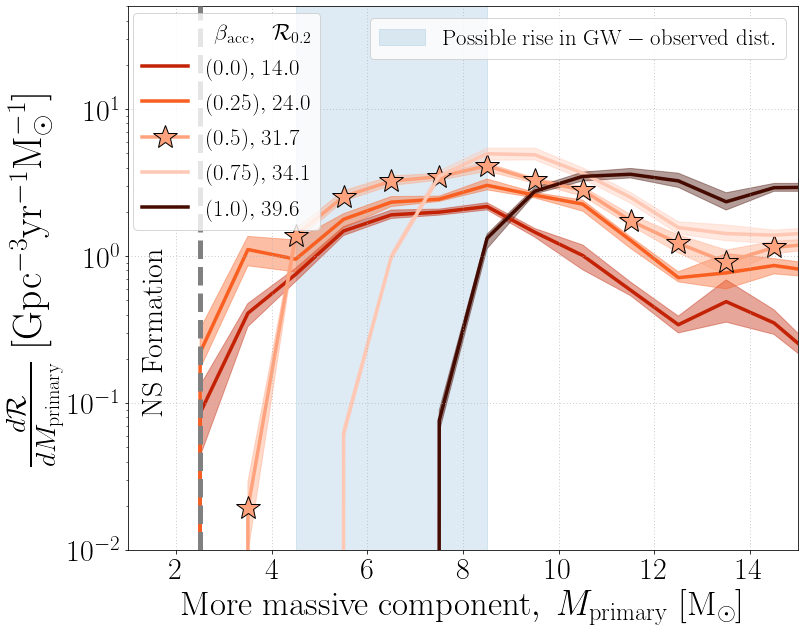

In [4]:
beta_list = [0.0, 0.25,0.5, 0.75,1.0]

plot_mass_distribution(sim_sets =  ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED'%(BETA) for BETA in beta_list],
                       markers = ['','','*','','',''], show_hist = True, show_KDE = False, 
                       leg_args = {'loc':'upper left', 'bbox_to_anchor':(-0.01,1.01), 'title_fontsize':'23', 'fontsize':'23', 'title':r'$\beta_{\rm{acc} }, \hphantom{x} \mathcal{R}_{0.2}$'}, leg1_args = {'loc':'upper right', 'fontsize':'23'},
                       colors  = ['#c32204', '#f95f21','#ffa37e','#ffc8b5', '#450b01'], #oranges
                       bootstrap = True, bootstraps = 50, 
                       save_plot=True,  save_name = 'betaVariations_zeta6.0FryerDelayed_HR.pdf',
                       labels = [r'$(%s), \ $'%(b) for b in beta_list ])




# fcore variations

!!!!!! sim_set faccFIXEDbeta0.5fcore0.8zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 0 

sum(rateDCO_mask) 417521
len(DCO[rateDCO_mask]) 417521 np.shape(intrinsic_rate_density) (417521, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 840831 sum(R_pessimistic_CE) 417521 sum(R_immediateRLOF) 417521 sum(R_notCHE) 401045
i_redshift 4 ==> z = 0.2
$(0.31), \ $  len(table)= 97637  Rate =  4.179178380801518  Gpc-3 yr-1
nplot 0 

Bootstrapping $(0.31), \ $:[############################################################] 50/50
nplot 0 len(colors) 5
!!!!!! sim_set faccFIXEDbeta0.5fcore0.9zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 1 

sum(rateDCO_mask) 976771
len(DCO[rateDCO_mask]) 976771 np.shape(intrinsic_rate_density) (976771, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 1617964 sum(R_pessimistic_CE) 976771 sum(R_immediateRLOF) 976771 sum(R_notCHE) 972352
i_redshift 4 ==> z = 0.2
$(0.31), \ $  len(table)= 170578  Rate =  12.74206338259878  Gpc-3 yr-1
nplot 1 

Bootstrapping $(0.31), \ $:[##################

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


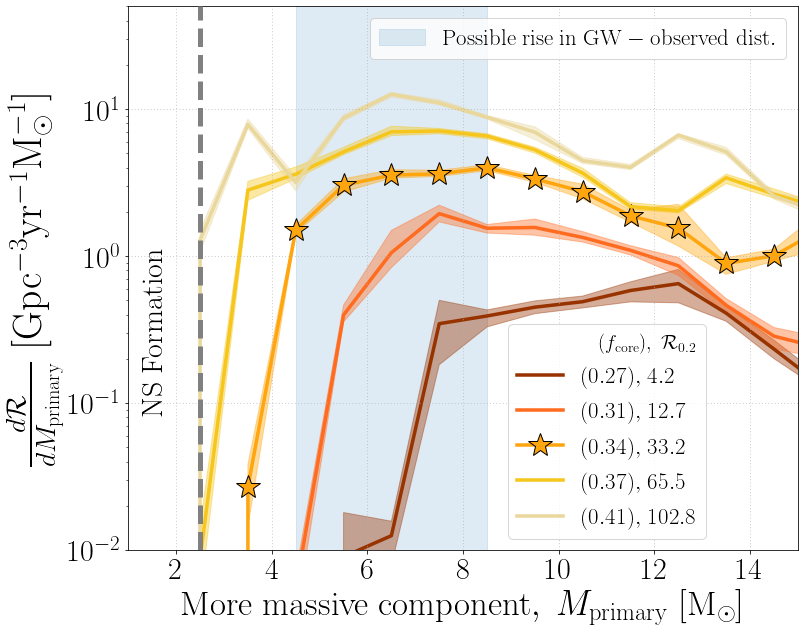

In [5]:
xcore_list =  [0.8,0.9,1.0,1.1,1.2] 
#  'faccFIXEDbeta0.5fcore%szetaHG6.0RemMassFRYER2012SNDELAYED'

Fc1_list = [xcore*0.34 for xcore in xcore_list]


plot_mass_distribution(sim_sets =  ['faccFIXEDbeta0.5fcore%szetaHG6.0RemMassFRYER2012SNDELAYED'%(xcore) for xcore in xcore_list ],
                       markers = ['','','*','','',''], 
                       z_bin_edges = [0,0.5], show_hist = True, show_KDE = False, 
                       leg_args = {'loc':'lower left', 'bbox_to_anchor':(0.55,0.0), 'title_fontsize':'20','fontsize':'23', 'title':r'$(f_{\mathrm{core}}), \ \mathcal{R}_{0.2} $'}, 
                       leg1_args = {'loc':'upper right', 'fontsize':'23'},
                       colors = ['#983300','#ff6b1f', '#ffa50e', '#f6c61c', '#e9d79c'], #yellow colors 
                       bootstrap = True, bootstraps = 50, 
                       save_plot=True,  save_name = 'fcoreVariations_betaFIXEDbeta0.5zeta6.0FryerDelayed_HR.pdf',
                       labels = [r'$(%s), \ $'%(np.round(fc,2) ) for fc in Fc1_list ],)




# dMSN variations

!!!!!! sim_set faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix0.5SNDELAYED
nplot 0 

sum(rateDCO_mask) 1254535
len(DCO[rateDCO_mask]) 1254535 np.shape(intrinsic_rate_density) (1254535, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 1914216 sum(R_pessimistic_CE) 1254535 sum(R_immediateRLOF) 1254535 sum(R_notCHE) 1251035
i_redshift 4 ==> z = 0.2
$1.0, \ $  len(table)= 126123  Rate =  4.768089496208499  Gpc-3 yr-1
nplot 0 

Bootstrapping $1.0, \ $:[############################################################] 50/50
!!!!!! sim_set faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix1.0SNDELAYED
nplot 1 

sum(rateDCO_mask) 1472411
len(DCO[rateDCO_mask]) 1472411 np.shape(intrinsic_rate_density) (1472411, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 2253907 sum(R_pessimistic_CE) 1472411 sum(R_immediateRLOF) 1472411 sum(R_notCHE) 1468881
i_redshift 4 ==> z = 0.2
$1.0, \ $  len(table)= 148143  Rate =  6.14537775623873  Gpc-3 yr-1
nplot 1 

Bootstrapping $1.0, \ $:[#########################################

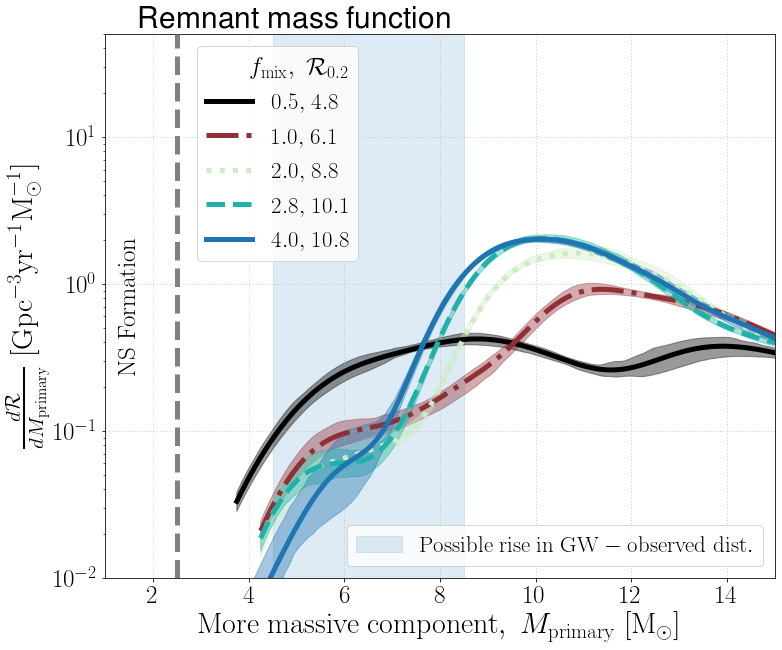

In [16]:
# fmix_list =  [0.5, 0.7, 1.0, 1.4, 2.0, 2.8, 4.0] 
fmix_list =  [0.5, 1.0,  2.0, 2.8, 4.0] 

# 'faccTHERMALzetaHG5.5RemMassFRYER2022fmix%sSNDELAYED'

plot_mass_distribution(sim_sets =  ['faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2022fmix%sSNDELAYED'%(fmix) for fmix in fmix_list], #FIXEDbeta0.5
                       linestyles = ['-','-.', ':', '--', '-', '-.', ':'], markers = ['*','','','','','', ''],
                       show_hist = False, show_KDE = True, kde_width = 0.2, bins = np.arange(1.,50,0.5),
                       leg_args = {'loc':'upper left', 'bbox_to_anchor':(0.12,1.0), 'fontsize':'23', 'title':r'$f_{\mathrm{mix}}, \ \mathcal{R}_{0.2}$'}, leg1_args = {'loc':'lower right', 'fontsize':'23'},
#                        colors = ['#000000', '#903036', '#d5b196', '#faf6c9', '#cdecc4', '#1fb2aa', '#1f75b2'], # Seagreen - burgundy
                       colors = ['#000000', '#903036', '#cdecc4', '#1fb2aa', '#1f75b2'], # Seagreen - burgundy
                       bootstrap = True, bootstraps = 50,  
                       save_plot=True, save_name = 'dMsnVariations_betaFIXED0.5zeta6.0FryerDelayed_HR.pdf',
                       labels = [r'$%s, \ $'%(f) for f in fmix_list ], title_text = 'Remnant mass function')



#                        colors = ['#051126', '#4c3f77', '#7c587f', '#a4bcbc', '#579fab', '#2680a6', '#005a8a'], # Blues


# gamma variations

In [ ]:
# f_cir 0 means NOTHING in circumbinary disk, everything in isotropic reemission
# f_cir 1 means EVERYTHING in circumbinary disk
fcircum_list = [0.0, 0.25,0.5, 0.75,1.0]

plot_mass_distribution(sim_dir = proj_dir+ '/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', sim_sets =  ['faccFIXEDbeta0.5gammaMIXTUREfcircum%szetaHG6.0RemMassFRYER2012SNDELAYED'%(fcirc) for fcirc in fcircum_list],
                       markers = ['*','','','','',''], 
                       z_bin_edges = [0,0.5], show_hist = False, show_KDE = True, 
                       leg_args = {'loc':'upper left', 'bbox_to_anchor':(0.,1.), 'fontsize':'23', 'title':r'$f_{\rm{disk}}, \ \mathcal{R}_{0.2}$'}, leg1_args = {'loc':'upper center', 'fontsize':'23'},
                       colors  = ['#170f7d','#392fbd', '#8632bb', '#ba56b8', '#d787bd' ], #Purple-pink
                       bootstrap = True, bootstraps = 50, 
                       save_plot=True, save_name = 'gammaVariations_betaFIXED0.5zeta6.0FryerDelayed_HR.pdf',
                       labels = [r'$%s, \ $'%(fcir) for fcir in fcircum_list ])




!!!!!! sim_set faccFIXEDbeta0.5gammaMIXTUREfcircum0.0zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 0 

sum(rateDCO_mask) 1415127
len(DCO[rateDCO_mask]) 1415127 np.shape(intrinsic_rate_density) (1415127, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 2534225 sum(R_pessimistic_CE) 1415127 sum(R_immediateRLOF) 1415127 sum(R_notCHE) 1411800
i_redshift 4 ==> z = 0.2
$0.25, \ $  len(table)= 218503  Rate =  33.09370868744853  Gpc-3 yr-1
nplot 0 

Bootstrapping $0.25, \ $:[############################################################] 50/50
nplot 0 len(colors) 5
!!!!!! sim_set faccFIXEDbeta0.5gammaMIXTUREfcircum0.25zetaHG6.0RemMassFRYER2012SNDELAYED
nplot 1 

sum(rateDCO_mask) 2792797
len(DCO[rateDCO_mask]) 2792797 np.shape(intrinsic_rate_density) (2792797, 200)
sum(np.logical_or(BBH_bool, BHNS_bool)) 3440512 sum(R_pessimistic_CE) 2792797 sum(R_immediateRLOF) 2792797 sum(R_notCHE) 2790142
i_redshift 4 ==> z = 0.2
$0.25, \ $  len(table)= 1994813  Rate =  122.86706935334438  Gpc-3 yr-1
nplot 1 

Bootstr

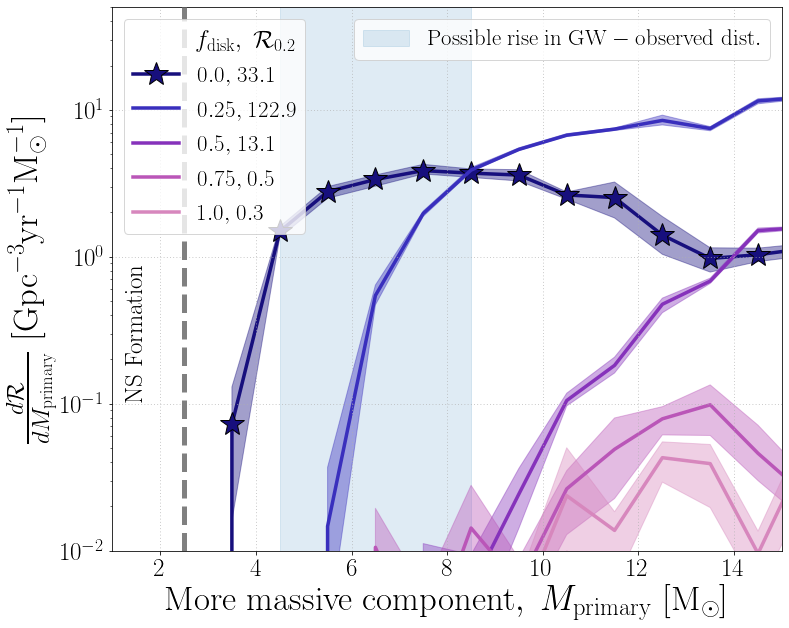

In [5]:
# f_cir 0 means NOTHING in circumbinary disk, everything in isotropic reemission
# f_cir 1 means EVERYTHING in circumbinary disk
fcircum_list = [0.0, 0.25,0.5, 0.75,1.0]

plot_mass_distribution(sim_dir = proj_dir+ '/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', sim_sets =  ['faccFIXEDbeta0.5gammaMIXTUREfcircum%szetaHG6.0RemMassFRYER2012SNDELAYED'%(fcirc) for fcirc in fcircum_list],
                       markers = ['*','','','','',''], 
                       z_bin_edges = [0,0.5], show_hist = True, show_KDE = False, 
                       leg_args = {'loc':'upper left', 'bbox_to_anchor':(0.,1.), 'fontsize':'23', 'title':r'$f_{\rm{disk}}, \ \mathcal{R}_{0.2}$'}, 
                       leg1_args = {'loc':'upper right', 'fontsize':'23'},
                       colors  = ['#170f7d','#392fbd', '#8632bb', '#ba56b8', '#d787bd' ], #Purple-pink
                       bootstrap = True, bootstraps = 50, 
                       save_plot=True, save_name = 'gammaVariations_betaFIXED0.5zeta6.0FryerDelayed_hist.pdf',
                       labels = [r'$%s, \ $'%(fcir) for fcir in fcircum_list ])


